## ## GSEA Analysis of Differentially Expressed Genes in Epithelial PLAUR+ vs PLAUR- Cells

In [25]:
import scanpy as sc  # For single-cell RNA-seq data analysis.
import scvi  # For probabilistic modeling of single-cell data.
import numpy as np # For numerical computing.
import pandas as pd  # For data manipulation.   
import gseapy as gp  # For enrichment analysis.
import seaborn as sns  # For data visualization.
import matplotlib.pyplot as plt  # For data visualization.

In [1]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"


In [4]:
# Load the epithelial cell subset AnnData object from an h5ad file
epithelial_cells = sc.read_h5ad(f'{base_data_path}/epith_subset_plaur_status.h5ad')


In [5]:
# Load the saved SCVI model and link it to the loaded epithelial_cells AnnData object
model = scvi.model.SCVI.load(f'{base_data_path}/model_PLAUR_Status.model_3', epithelial_cells)
model

INFO     File /Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data/model_PLAUR_Status.model_3/model.pt already      
         downloaded                                                                                                


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = tor

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [6]:
# Get the latent representations from the SCVI model and store them in the AnnData object
epithelial_cells.obsm['X_scVI'] = model.get_latent_representation()


In [7]:
# Get the normalized expression values from the SCVI model and store them in a new layer of the AnnData object
epithelial_cells.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)


In [8]:
# Perform differential expression analysis between PLAUR+ and PLAUR- cells using the SCVI model
scvi_de_4 = model.differential_expression(
    idx1=epithelial_cells.obs['PLAUR_Status'] == 'PLAUR+',
    idx2=epithelial_cells.obs['PLAUR_Status'] == 'PLAUR-'
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Display the top rows of the differential expression results
scvi_de_4.head()


proba_de  proba_not_de  bayes_factor        scale1        scale2  \
gene_symbol                                                                     
IL1RN          0.9978        0.0022      6.117091  2.248684e-04  2.232106e-05   
DHRS9          0.9976        0.0024      6.029880  8.271878e-04  2.246382e-05   
AL133346.1     0.9976        0.0024      6.029880  4.200855e-07  4.836776e-06   
IL17C          0.9970        0.0030      5.806135  1.665258e-05  5.140762e-07   
PLAUR          0.9966        0.0034      5.680571  5.805159e-04  6.604681e-05   

             pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
gene_symbol                                                                   
IL1RN                 0.0   0.25  3.361098    3.314204  1.205576  -1.235434   
DHRS9                 0.0   0.25  5.293580    5.162693  2.097781  -1.847539   
AL133346.1            0.0   0.25 -3.365305   -3.907897  2.623561 -10.302832   
IL17C                 0.0   0.25  4.918939    4.965523  1.805833  -6.580549   
PLAUR                 0.0   0.25  3.077616    3.119252  0.989959  -0.693695   

               lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
gene_symbol                                                           
IL1RN         8.141120   0.771873   0.240713               0.365367   
DHRS9        13.645609   3.978842   0.046362               0.635247   
AL133346.1    8.200106   0.001228   0.014430               0.001228   
IL17C        11.467968   0.017194   0.000921               0.008597   
PLAUR         6.854748   5.261361   0.319312               0.776788   

             non_zeros_proportion2  raw_normalized_mean1  \
gene_symbol                                                
IL1RN                     0.095794              1.346631   
DHRS9                     0.012281              7.499516   
AL133346.1                0.013202              0.004200   
IL17C                     0.000921              0.036152   
PLAUR                     0.165183              6.326602   

             raw_normalized_mean2  is_de_fdr_0.05  
gene_symbol                                        
IL1RN                    0.150446            True  
DHRS9                    0.025013            True  
AL133346.1               0.022306            True  
IL17C                    0.000885            True  
PLAUR                    0.386652            True

In [10]:
# Filter for genes that are differentially expressed with FDR < 0.05 and |log fold change| > 0.5
scvi_de_4 = scvi_de_4[(scvi_de_4['is_de_fdr_0.05']) & (abs(scvi_de_4['lfc_mean']) > 0.5)]

# Sort the filtered results by log fold change to see the most upregulated and downregulated genes
scvi_de_4 = scvi_de_4.sort_values('lfc_mean')

# Display the filtered and sorted differential expression results
scvi_de_4.head(20)  # Show the top 20 differentially expressed genes

proba_de  proba_not_de  bayes_factor        scale1    scale2  \
gene_symbol                                                                 
ANGPTL7        0.9914        0.0086      4.747355  1.534366e-07  0.000015   
HBG1           0.9838        0.0162      4.106411  4.031081e-03  0.058547   
DES            0.9928        0.0072      4.926447  2.606237e-06  0.000087   
CDX2           0.9880        0.0120      4.410775  7.650028e-07  0.000013   
KCNK17         0.9892        0.0108      4.517349  5.209059e-07  0.000011   
CCL11          0.9886        0.0114      4.462676  1.962606e-06  0.000078   
HMGCS2         0.9864        0.0136      4.283991  8.309510e-07  0.000038   
RERGL          0.9878        0.0122      4.394043  3.409560e-06  0.000087   
AL035670.1     0.9838        0.0162      4.106411  1.088190e-07  0.000003   
EMILIN3        0.9832        0.0168      4.069433  4.515203e-07  0.000018   
GP1BB          0.9876        0.0124      4.377580  9.589638e-06  0.000277   
ADH1B          0.9828        0.0172      4.045496  3.034490e-06  0.000160   
LINC02206      0.9876        0.0124      4.377580  9.785811e-08  0.000002   
GRIN2A         0.9788        0.0212      3.832326  2.908642e-06  0.000037   
DPT            0.9906        0.0094      4.657600  2.265696e-05  0.000494   
OGN            0.9820        0.0180      3.999219  1.176657e-05  0.000364   
P2RY14         0.9908        0.0092      4.679308  1.243467e-06  0.000028   
ROBO2          0.9848        0.0152      4.171142  3.762853e-07  0.000015   
TSIX           0.9886        0.0114      4.462676  2.035543e-06  0.000045   
NTNG1          0.9876        0.0124      4.377580  4.276619e-07  0.000016   

             pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
gene_symbol                                                                   
ANGPTL7               0.0   0.25 -6.531225   -6.817583  3.495206 -25.323761   
HBG1                  0.0   0.25 -6.451025   -6.936473  8.543363 -49.117916   
DES                   0.0   0.25 -5.689874   -5.892031  2.514727 -14.434990   
CDX2                  0.0   0.25 -5.652761   -6.109511  2.974550 -13.159259   
KCNK17                0.0   0.25 -5.461837   -5.725719  2.956749 -13.329299   
CCL11                 0.0   0.25 -5.268199   -5.691109  2.833690 -15.833478   
HMGCS2                0.0   0.25 -5.219649   -5.848218  3.279313 -17.139729   
RERGL                 0.0   0.25 -5.214173   -5.855058  3.244077 -14.602983   
AL035670.1            0.0   0.25 -5.202618   -5.697814  3.149170 -26.471939   
EMILIN3               0.0   0.25 -5.200404   -5.586502  2.597598 -20.157598   
GP1BB                 0.0   0.25 -5.085768   -5.211559  3.164926 -16.320879   
ADH1B                 0.0   0.25 -5.071860   -5.106204  3.091508 -13.482971   
LINC02206             0.0   0.25 -5.042489   -5.362651  2.938630 -24.691063   
GRIN2A                0.0   0.25 -5.026915   -5.766971  3.469236 -14.564177   
DPT                   0.0   0.25 -5.015877   -5.220360  2.204711 -12.909637   
OGN                   0.0   0.25 -4.958424   -5.129552  2.889318 -12.458679   
P2RY14                0.0   0.25 -4.954448   -5.089970  2.203531 -10.981789   
ROBO2                 0.0   0.25 -4.904445   -5.208069  3.036971 -21.440731   
TSIX                  0.0   0.25 -4.863324   -5.424217  3.219560 -13.718092   
NTNG1                 0.0   0.25 -4.832368   -5.009244  2.736191 -16.836132   

               lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
gene_symbol                                                           
ANGPTL7      11.521933   0.000000   0.162726               0.000000   
HBG1         42.289719   0.011974   0.519804               0.003684   
DES           5.315160   0.000614   0.008904               0.000614   
CDX2          5.372725   0.049125   0.076451               0.026098   
KCNK17        6.527800   0.001228   0.016887               0.000614   
CCL11         6.601557   0.000000   0.003684               0.000000   
HMGCS2     

In [11]:
# Retain genes with a mean normalized expression greater than 0.5 in either PLAUR+ or PLAUR- groups
scvi_de_4 = scvi_de_4[(scvi_de_4['raw_normalized_mean1'] > 0.5) | (scvi_de_4['raw_normalized_mean2'] > 0.5)]

# Display the refined differential expression results
scvi_de_4.head(20)  # Show the top 20 differentially expressed genes after filtering


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
gene_symbol                                                                 
HBG1           0.9838        0.0162      4.106411  4.031081e-03  0.058547   
ADH1B          0.9828        0.0172      4.045496  3.034490e-06  0.000160   
DPT            0.9906        0.0094      4.657600  2.265696e-05  0.000494   
OGN            0.9820        0.0180      3.999219  1.176657e-05  0.000364   
PGC            0.9806        0.0194      3.922891  7.768625e-06  0.000107   
INMT           0.9750        0.0250      3.663561  6.015644e-07  0.000031   
PPY            0.9794        0.0206      3.861649  1.023865e-06  0.000024   
A4GNT          0.9798        0.0202      3.881665  1.511536e-06  0.000030   
GP2            0.9800        0.0200      3.891820  3.347569e-05  0.000226   
CD34           0.9882        0.0118      4.427785  2.450653e-06  0.000058   
TNXB           0.9704        0.0296      3.489934  6.280509e-06  0.000256   
DMBT1          0.9748        0.0252      3.655388  1.930646e-05  0.000292   
SFRP1          0.9646        0.0354      3.305001  5.233403e-06  0.000122   
ITIH5          0.9824        0.0176      4.022099  3.778914e-06  0.000084   
CILP           0.9714        0.0286      3.525331  1.935014e-06  0.000059   
KIAA1324       0.9834        0.0166      4.081613  5.513701e-06  0.000055   
PLAC9          0.9750        0.0250      3.663561  1.514001e-05  0.000229   
PRSS2          0.9724        0.0276      3.561951  9.186736e-05  0.000579   
MFAP5          0.9620        0.0380      3.231428  6.525566e-06  0.000179   
PIK3C2G        0.9676        0.0324      3.396660  8.702382e-06  0.000125   

             pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
gene_symbol                                                                   
HBG1                  0.0   0.25 -6.451025   -6.936473  8.543363 -49.117916   
ADH1B                 0.0   0.25 -5.071860   -5.106204  3.091508 -13.482971   
DPT                   0.0   0.25 -5.015877   -5.220360  2.204711 -12.909637   
OGN                   0.0   0.25 -4.958424   -5.129552  2.889318 -12.458679   
PGC                   0.0   0.25 -4.427148   -4.614299  2.401197 -12.038922   
INMT                  0.0   0.25 -4.412748   -4.333938  3.295689 -17.094700   
PPY                   0.0   0.25 -4.393222   -4.731497  3.534814 -18.990023   
A4GNT                 0.0   0.25 -4.358879   -4.570337  2.580988 -11.164968   
GP2                   0.0   0.25 -4.271465   -4.555386  3.190955 -14.721403   
CD34                  0.0   0.25 -3.993984   -4.241951  2.577569 -11.236678   
TNXB                  0.0   0.25 -3.991685   -3.946118  2.948997 -13.986382   
DMBT1                 0.0   0.25 -3.953404   -4.486193  3.501644 -13.325385   
SFRP1                 0.0   0.25 -3.697879   -3.621306  2.930961 -11.813055   
ITIH5                 0.0   0.25 -3.594884   -3.745037  2.624523 -13.785784   
CILP                  0.0   0.25 -3.585009   -3.538285  3.126160 -17.760597   
KIAA1324              0.0   0.25 -3.539640   -3.830684  1.951065 -14.265622   
PLAC9                 0.0   0.25 -3.434645   -3.451667  2.377191 -21.337917   
PRSS2                 0.0   0.25 -3.434423   -3.700037  2.485651 -11.173593   
MFAP5                 0.0   0.25 -3.413130   -3.251283  3.272266 -13.439205   
PIK3C2G               0.0   0.25 -3.310897   -3.643579  2.615322 -10.534492   

               lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
gene_symbol                                                           
HBG1         42.289719   0.011974   0.519804               0.003684   
ADH1B         6.097070   0.000307   0.424624               0.000307   
DPT           3.438823   0.013509   0.778631               0.006141   
OGN           5.100657   0.003377   0.730733               0.001842   
PGC           3.778997   0.497697  10.585258               0.025177   
INMT         11.169241   0.001228   0.228739               0.001228   
PPY        

In [12]:
# Save the filtered differential expression results to a CSV file
scvi_de_4.to_csv(f'{base_data_path}/scvi_DEG_results_PLAUR_whole.csv', index=True)


In [15]:
# Extract the list of gene names from the differential expression results DataFrame
gene_list_PLAUR = scvi_de_4.index.tolist()
gene_list_PLAUR[:10]  # Display the first 10 genes in the list


['HBG1', 'ADH1B', 'DPT', 'OGN', 'PGC', 'INMT', 'PPY', 'A4GNT', 'GP2', 'CD34']

In [16]:
# Initialize the new list to store significant genes
significant_genesPLAUR = []

# Iterate through the genes in gene_list_PLAUR
for gene in gene_list_PLAUR:
    # Check if the gene has lfc_mean > 0.5 in scvi_de_4
    if gene in scvi_de_4.index and scvi_de_4.loc[gene, 'lfc_mean'] > 0.5:
        significant_genesPLAUR.append(gene)

# significant_genesPLAUR now contains genes from gene_list_PLAUR with lfc_mean > 0.5 in scvi_de_4


In [17]:
# Print the number of significant genes in the list
print("Number of significant genes:", len(significant_genesPLAUR))

# Print the list of significant genes
print("Significant genes:", significant_genesPLAUR)


Number of significant genes: 390
Significant genes: ['VSIG1', 'CTSK', 'MT2A', 'SERPINE2', 'IGFBP6', 'SPP1', 'UBE2B', 'RAP1B', 'APCS', 'MTPN', 'RAB1A', 'CCN3', 'CCNG2', 'ATP6V0C', 'ARL4A', 'RNF141', 'CASP4', 'JOSD1', 'AZIN1', 'RAB7A', 'RALBP1', 'HBG2', 'ZNF267', 'SEC23A', 'HMGB2', 'PTPN2', 'IAPP', 'MAP1LC3B', 'CARD19', 'SIAH1', 'PAK2', 'YPEL5', 'PPP2R2A', 'TUBA4A', 'SMS', 'ARPC5', 'LACTB', 'BLVRB', 'ITPKC', 'OXSR1', 'SLC16A4', 'UBE2H', 'LY6E', 'REL', 'CLDND1', 'FXYD5', 'CD109', 'SEMA3C', 'OSER1', 'CDKN1A', 'CDV3', 'RALB', 'H3F3B', 'RBP4', 'RFFL', 'COLGALT1', 'PFKP', 'TRIB1', 'PLEKHB2', 'YWHAZ', 'CAST', 'EMP3', 'TMSB10', 'CTNNAL1', 'HIST3H2A', 'CD44', 'ARL6IP1', 'NOP10', 'SERP1', 'IFRD1', 'OSTF1', 'IGLC2', 'LDHA', 'SMIM6', 'RBCK1', 'LGALS3', 'PPDPF', 'PPP1R3B', 'PLK3', 'NRBF2', 'ITGB1', 'ARPC3', 'GPD2', 'AGTRAP', 'CAV1', 'KCTD9', 'IFI6', 'ARRDC3', 'METRNL', 'VAPA', 'CD9', 'ZBTB43', 'RIOK3', 'ECT2', 'CD69', 'PATL1', 'BRI3', 'APOC1', 'VDAC2', 'ARRDC4', 'TMBIM1', 'PPP1R15A', 'BCL2A1', 'PITX

In [18]:
# Initialize a list to store significant genes based on the criteria
significant_genesPLAUR = []

# Iterate through each gene in the gene list
for gene in gene_list_PLAUR:
    # Check if the gene exists in scvi_de_4 and has a log fold change greater than 0.5
    if gene in scvi_de_4.index and scvi_de_4.loc[gene, 'lfc_mean'] > 0.5:
        significant_genesPLAUR.append(gene)  # Add gene to the list if criteria are met


In [19]:
# Define a list of gene set libraries to use for enrichment analysis
gene_sets = [
    'MSigDB_Hallmark_2020',       # Hallmark pathways from MSigDB (2020)
    'KEGG_2021_Human',            # KEGG pathways for humans (2021)
    'WikiPathway_2023_Human',     # WikiPathways for humans (2023)
    'GO_Biological_Process_2023'  # GO biological processes (2023)
]


In [20]:
import importlib  # Importing the importlib module to reload modules
import utilities  # Importing the custom 'utilities' module

# Reloads the 'utilities' module to reflect any changes made to the module
importlib.reload(utilities)

from utilities import perform_gsea_and_plot

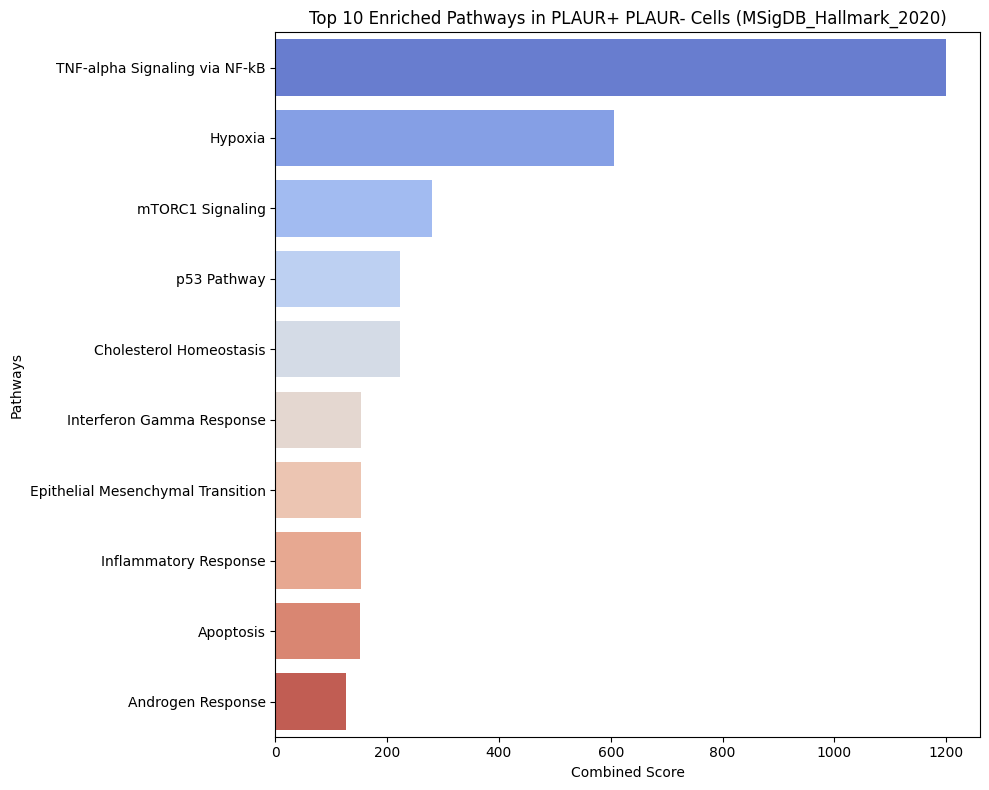

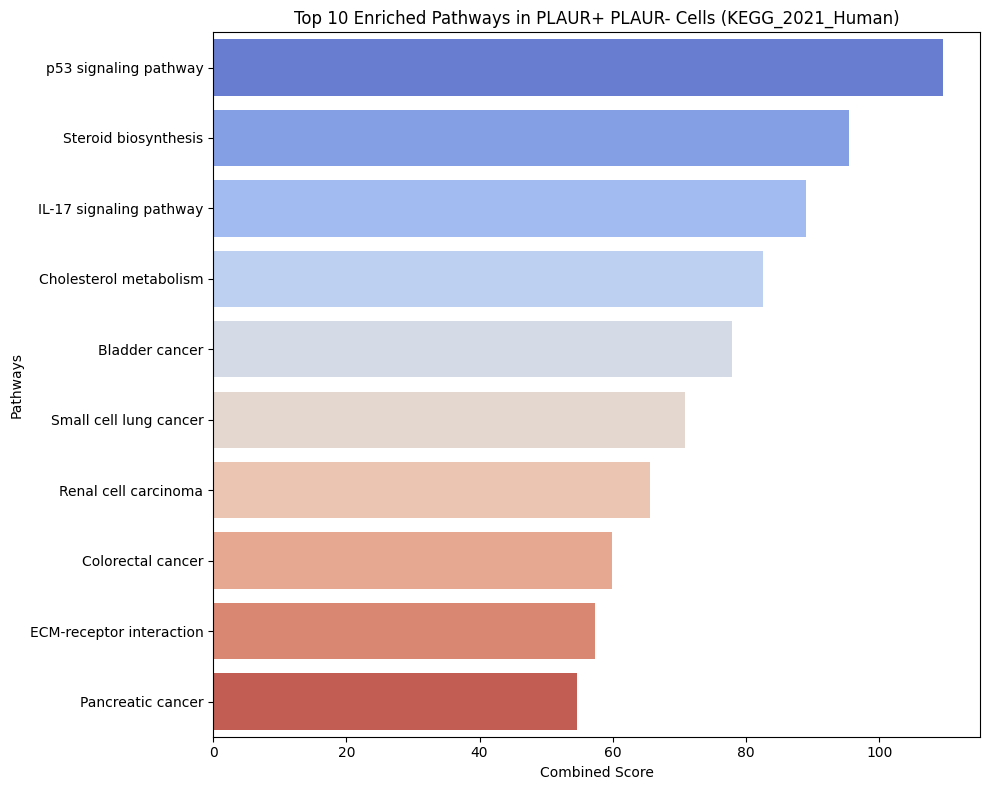

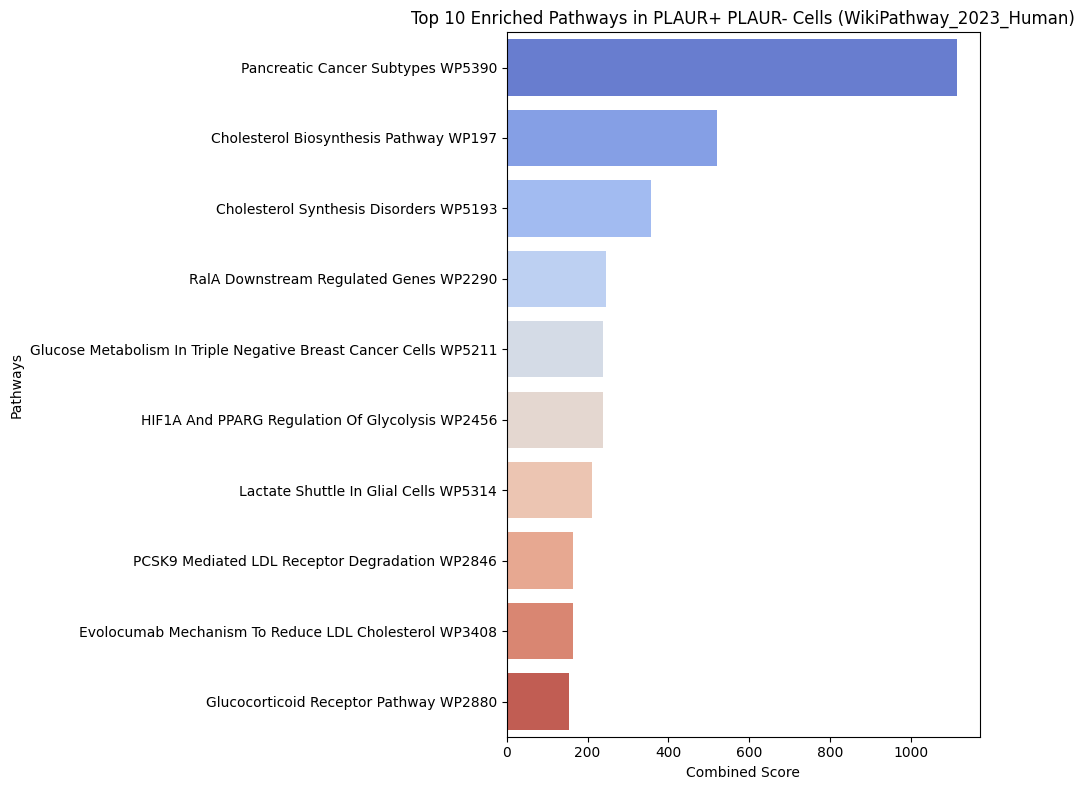

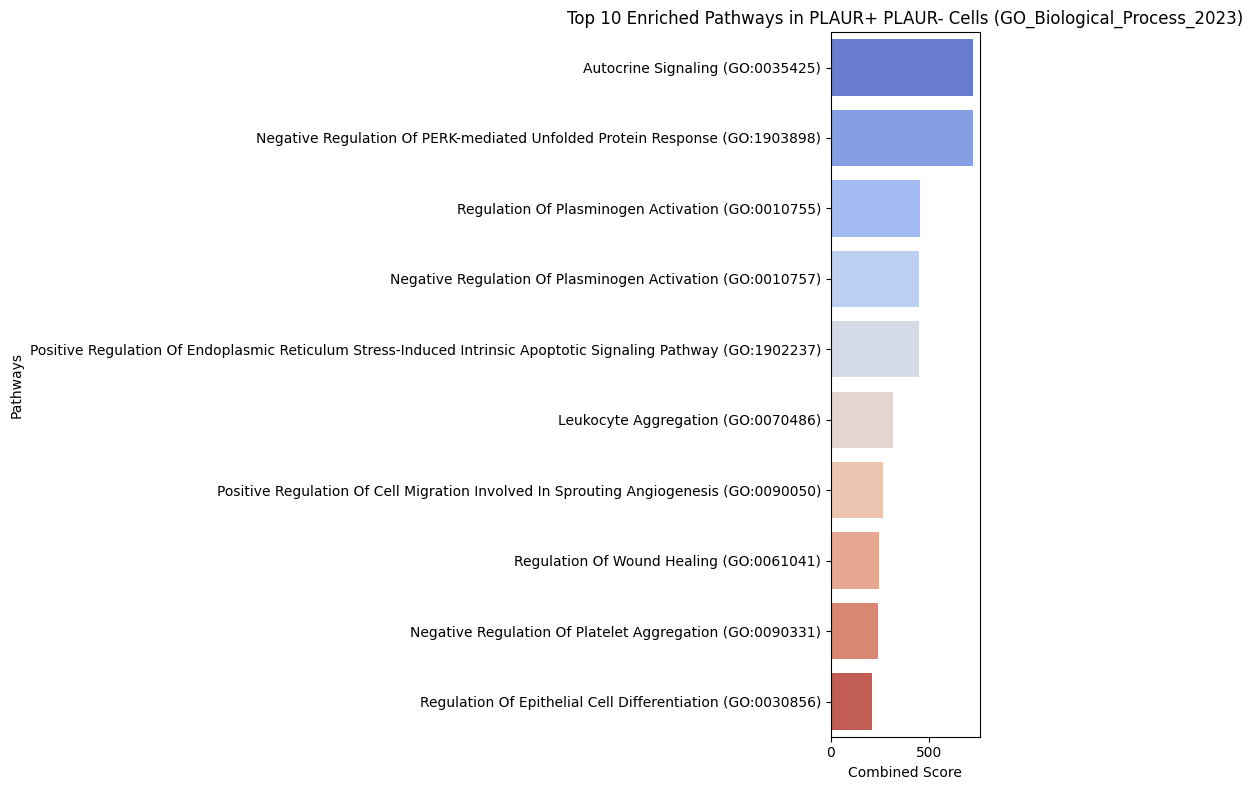

In [22]:
# Run GSEA and plot the results for significant_genesPLAUR with the specified gene sets
perform_gsea_and_plot(significant_genesPLAUR, 'PLAUR+ PLAUR-',gene_sets)

In [23]:
# Initialize the new list to store significantly downregulated genes
significant_genesPLAUR_down = []

# Iterate through the genes in gene_list_PLAUR
for gene in gene_list_PLAUR:
    # Check if the gene is in scvi_de_4 and has an lfc_mean < -0.5
    if gene in scvi_de_4.index and scvi_de_4.loc[gene, 'lfc_mean'] < -0.5:
        significant_genesPLAUR_down.append(gene)  # Add gene to the list if it meets criteria

# significant_genesPLAUR_down now contains genes from gene_list_PLAUR with lfc_mean < -0.5 in scvi_de_4


In [24]:
# Print the number of significant downregulated genes
print("Number of significant downregulated genes:", len(significant_genesPLAUR_down))

# Print the list of significant downregulated genes
print("Significant downregulated genes:", significant_genesPLAUR_down)


Number of significant downregulated genes: 400
Significant downregulated genes: ['HBG1', 'ADH1B', 'DPT', 'OGN', 'PGC', 'INMT', 'PPY', 'A4GNT', 'GP2', 'CD34', 'TNXB', 'DMBT1', 'SFRP1', 'ITIH5', 'CILP', 'KIAA1324', 'PLAC9', 'PRSS2', 'MFAP5', 'PIK3C2G', 'SCTR', 'GPC3', 'SLIT3', 'APOA4', 'CDCA7', 'SULT1C2', 'ALDOB', 'ELN', 'PPP1R1B', 'APOC3', 'ONECUT3', 'FBLN5', 'PRSS1', 'SMOC2', 'GSTM3', 'ONECUT2', 'PDGFRA', 'PRELP', 'SCN7A', 'LHFPL6', 'ABCA8', 'DCN', 'ZNF302', 'NFIA', 'APOA1', 'PLA2G2A', 'PKDCC', 'ABCA6', 'CLPS', 'GPM6B', 'MYL9', 'PLEKHS1', 'FBLN2', 'APOD', 'HNF1A-AS1', 'MXRA8', 'MT1M', 'SOD3', 'ANK3', 'LTBP4', 'ARFGEF3', 'LINC02532', 'PBX1', 'FXYD1', 'LTBP1', 'COL18A1', 'NKX6-2', 'LRIG3', 'MFAP4', 'SRPX', 'SPARCL1', 'SCARA5', 'AEBP1', 'NR2F2', 'ASPN', 'ZBTB16', 'CTSF', 'LAMA2', 'MRC2', 'NEXN', 'HBA1', 'CHRDL1', 'MEIS2', 'NEGR1', 'CFD', 'PLP1', 'FMOD', 'NDRG2', 'MEIS1', 'C1orf21', 'IGFBP5', 'FHL1', 'LUM', 'XIST', 'CLDN2', 'MATN2', 'MUC3A', 'HTRA1', 'THY1', 'FBLN1', 'CALD1', 'CXCL12', 'RA

## Quantile-Based Differential Expression Analysis of PLAUR+ vs PLAUR- Cells Using Trained SCVI Model (90th vs 10th Percentile)

In [26]:
# Extract the normalized expression values for the PLAUR gene from the SCVI-normalized layer in the epithelial cells AnnData object
plaured_expr = epithelial_cells[:, 'PLAUR'].layers['scvi_normalized']


In [27]:
# Check if the PLAUR expression data is a sparse matrix and convert it to a dense array if necessary
if not isinstance(plaured_expr, np.ndarray):
    plaured_expr = plaured_expr.toarray().flatten()  # Convert sparse matrix to dense array and flatten
else:
    plaured_expr = plaured_expr.flatten()  # Flatten if already dense


In [28]:
# Calculate the 90th and 10th percentiles of the PLAUR expression data
quantile_90 = np.percentile(plaured_expr, 90)
quantile_10 = np.percentile(plaured_expr, 10)


In [29]:
# Subset the epithelial_cells AnnData object based on high and low PLAUR expression
high_plaured_cells = epithelial_cells[plaured_expr >= quantile_90]  # Cells with PLAUR expression in the top 90th percentile
low_plaured_cells = epithelial_cells[plaured_expr <= quantile_10]   # Cells with PLAUR expression in the bottom 10th percentile


In [30]:
# Assign PLAUR expression status to each cell based on whether it falls into high, low, or intermediate categories
epithelial_cells.obs['PLAUR_Status'] = np.where(
    epithelial_cells.obs_names.isin(high_plaured_cells.obs_names), 'High_PLAUR',
    np.where(epithelial_cells.obs_names.isin(low_plaured_cells.obs_names), 'Low_PLAUR', 'Intermediate')
)


In [31]:
# Perform differential expression analysis between High_PLAUR and Low_PLAUR cells using the SCVI model
de_results = model.differential_expression(
    groupby="PLAUR_Status",   # Group cells by PLAUR_Status
    group1="High_PLAUR",      # Define group1 as High PLAUR cells
    group2="Low_PLAUR",       # Define group2 as Low PLAUR cells
    mode="change",            # Use log fold change mode for DE analysis
    delta=0.5                 # Set log fold change threshold at 0.5
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# Sort the differential expression results by log fold change (lfc_mean) in descending order
de_results_df = de_results.sort_values(by="lfc_mean", ascending=False)


In [33]:
# Identify upregulated genes in High_PLAUR cells with a log fold change > 0.5 and probability of differential expression > 0.9
upregulated_genes_high_plaured = de_results_df[(de_results_df['lfc_mean'] > 0.5) & (de_results_df['proba_de'] > 0.9)].index.tolist()


In [34]:
# Define a list of gene set libraries to use for enrichment analysis
gene_sets = [
    'MSigDB_Hallmark_2020',       # Hallmark pathways from MSigDB (2020)
    'KEGG_2021_Human',            # KEGG pathways for humans (2021)
    'WikiPathway_2023_Human',     # WikiPathways for humans (2023)
    'GO_Biological_Process_2023'  # Gene Ontology biological processes (2023)
]


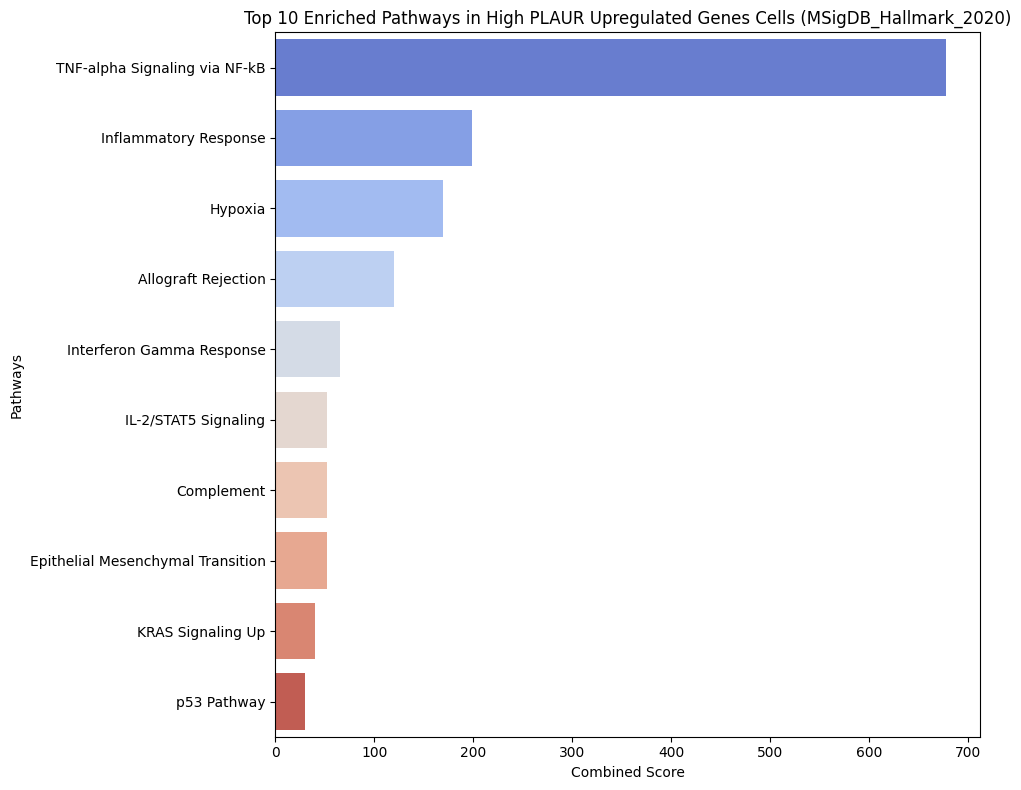

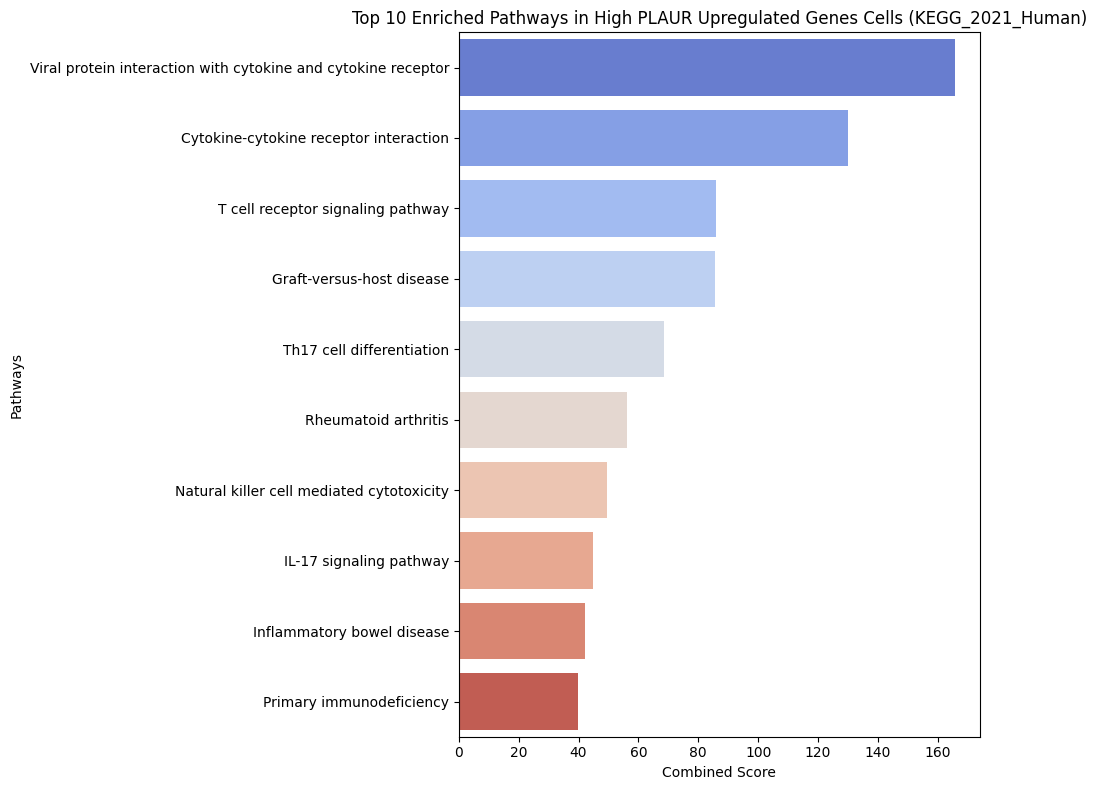

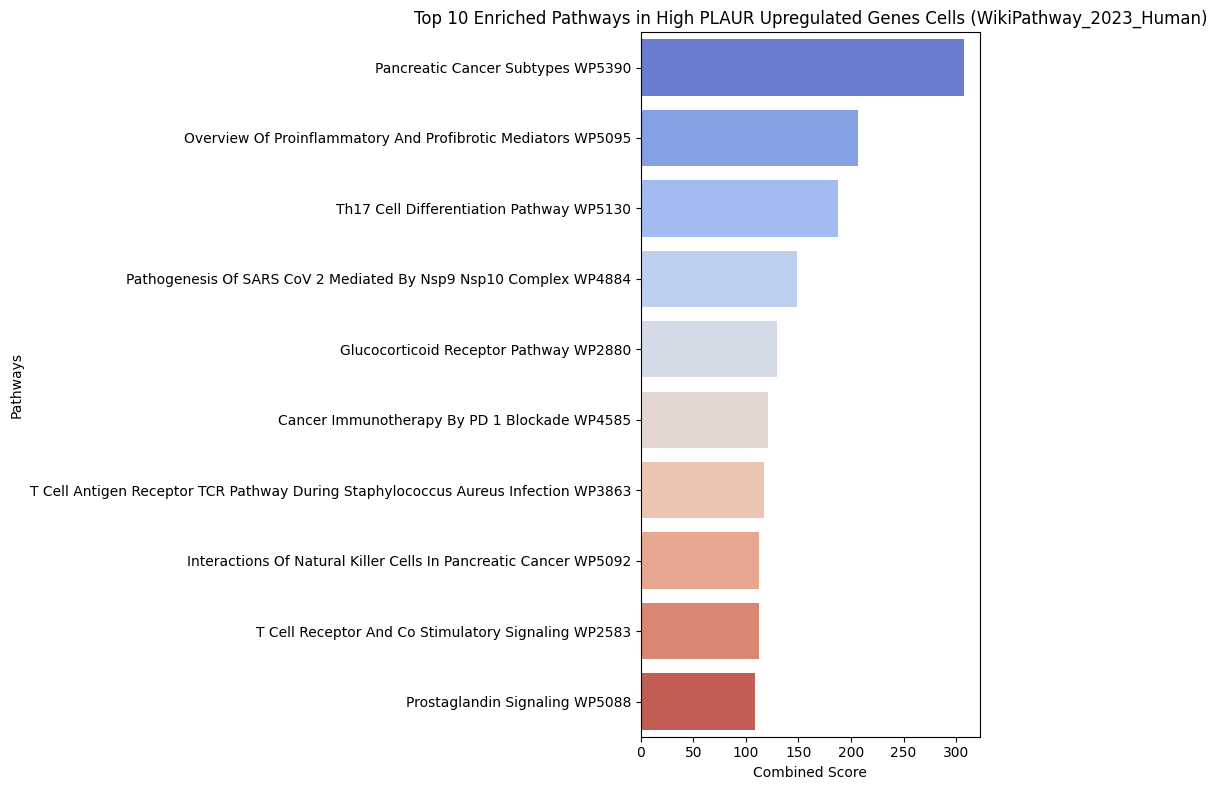

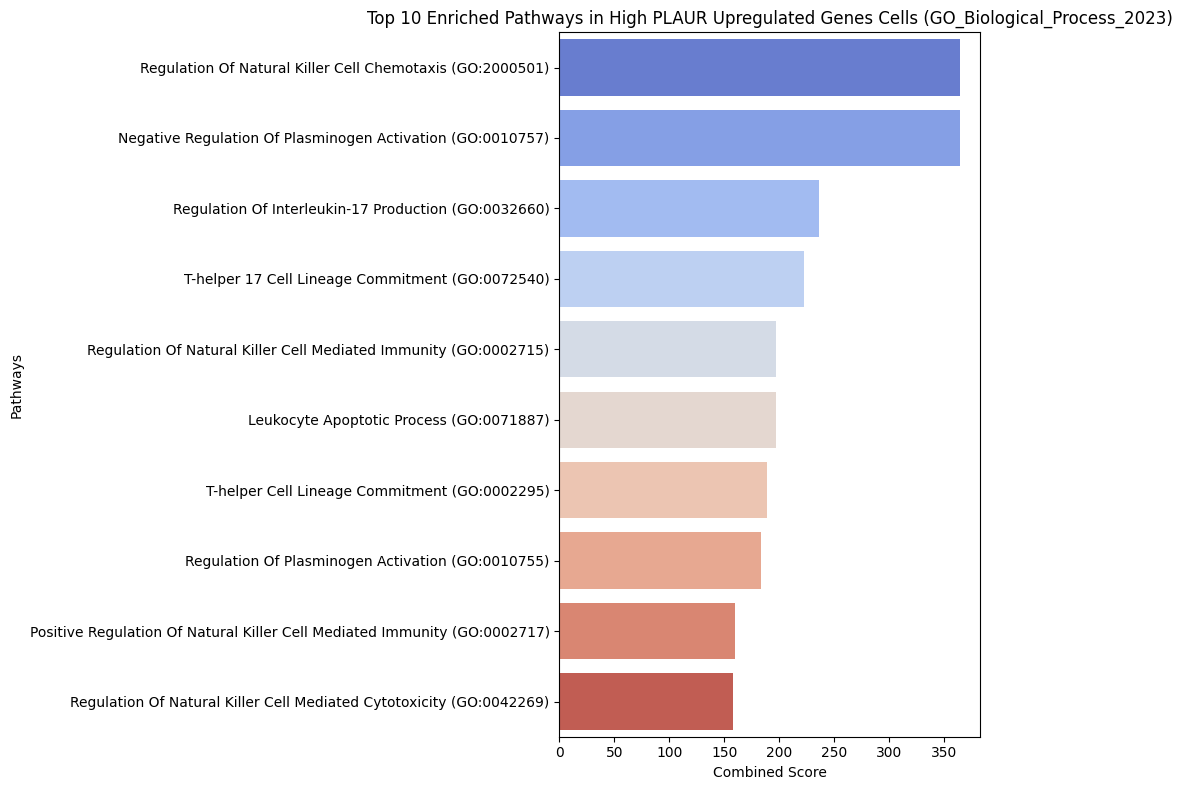

In [35]:
# Run GSEA and plot results for upregulated genes in High PLAUR cells
perform_gsea_and_plot(upregulated_genes_high_plaured, 'High PLAUR Upregulated Genes', gene_sets)

In [40]:
# Define masks for cells in the 90th and 10th quantiles of PLAUR expression
high_plaured_mask = plaured_expr >= quantile_90  # Mask for high PLAUR cells (90th percentile)
low_plaured_mask = plaured_expr <= quantile_10   # Mask for low PLAUR cells (10th percentile)

In [41]:
# Determine the number of cells in the 90th and 10th quantiles based on PLAUR expression
num_high_plaured_cells = np.sum(high_plaured_mask)  # Number of cells in the 90th percentile (high PLAUR)
num_low_plaured_cells = np.sum(low_plaured_mask)    # Number of cells in the 10th percentile (low PLAUR)


In [42]:

print("Number of High PLAUR cells (90th percentile):", num_high_plaured_cells)
print("Number of Low PLAUR cells (10th percentile):", num_low_plaured_cells)

Number of High PLAUR cells (90th percentile): 3257
Number of Low PLAUR cells (10th percentile): 3257


In [43]:
# Extract the normalized expression values for the PLAUR gene from the scvi_normalized layer
plaured_expr = epithelial_cells[:, 'PLAUR'].layers['scvi_normalized']


In [44]:
# Convert sparse matrix to dense array if necessary
if not isinstance(plaured_expr, np.ndarray):
    plaured_expr = plaured_expr.toarray().flatten()  # Convert to dense array and flatten
else:
    plaured_expr = plaured_expr.flatten()  # Flatten if already dense

In [45]:
# Calculate the 90th and 10th percentiles of PLAUR expression
quantile_90 = np.percentile(plaured_expr, 90)
quantile_10 = np.percentile(plaured_expr, 10)


In [46]:
# Subset the epithelial_cells AnnData object for cells with high and low PLAUR expression
high_plaured_cells = epithelial_cells[plaured_expr >= quantile_90]  # Cells with PLAUR expression in the top 90th percentile
low_plaured_cells = epithelial_cells[plaured_expr <= quantile_10]   # Cells with PLAUR expression in the bottom 10th percentile


In [47]:
# Label cells in the AnnData object based on PLAUR expression quantiles
epithelial_cells.obs['PLAUR_Status'] = np.where(
    epithelial_cells.obs_names.isin(high_plaured_cells.obs_names), 'High_PLAUR',
    np.where(epithelial_cells.obs_names.isin(low_plaured_cells.obs_names), 'Low_PLAUR', 'Intermediate')
)


In [48]:
# Perform differential expression analysis between High_PLAUR and Low_PLAUR cells
de_results = model.differential_expression(
    groupby="PLAUR_Status",  # Group cells by PLAUR_Status
    group1="High_PLAUR",     # Define High PLAUR cells as group1
    group2="Low_PLAUR",      # Define Low PLAUR cells as group2
    mode="change",           # Use log fold change mode for DE analysis
    delta=0.5                # Set log fold change threshold at 0.5
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
# Sort the differential expression results by log fold change in descending order
de_results_df = de_results.sort_values(by="lfc_mean", ascending=False)


In [50]:
# Identify downregulated genes in High_PLAUR cells
# Criteria: lfc_mean < -0.5 and proba_de > 0.9
downregulated_genes_high_plaured = de_results_df[(de_results_df['lfc_mean'] < -0.5) & (de_results_df['proba_de'] > 0.9)].index.tolist()


In [51]:
# Define gene sets for enrichment analysis
gene_sets = [
    'MSigDB_Hallmark_2020',       # Hallmark pathways from MSigDB (2020)
    'KEGG_2021_Human',            # KEGG pathways for humans (2021)
    'WikiPathway_2023_Human',     # WikiPathways for humans (2023)
    'GO_Biological_Process_2023'  # Gene Ontology biological processes (2023)
]


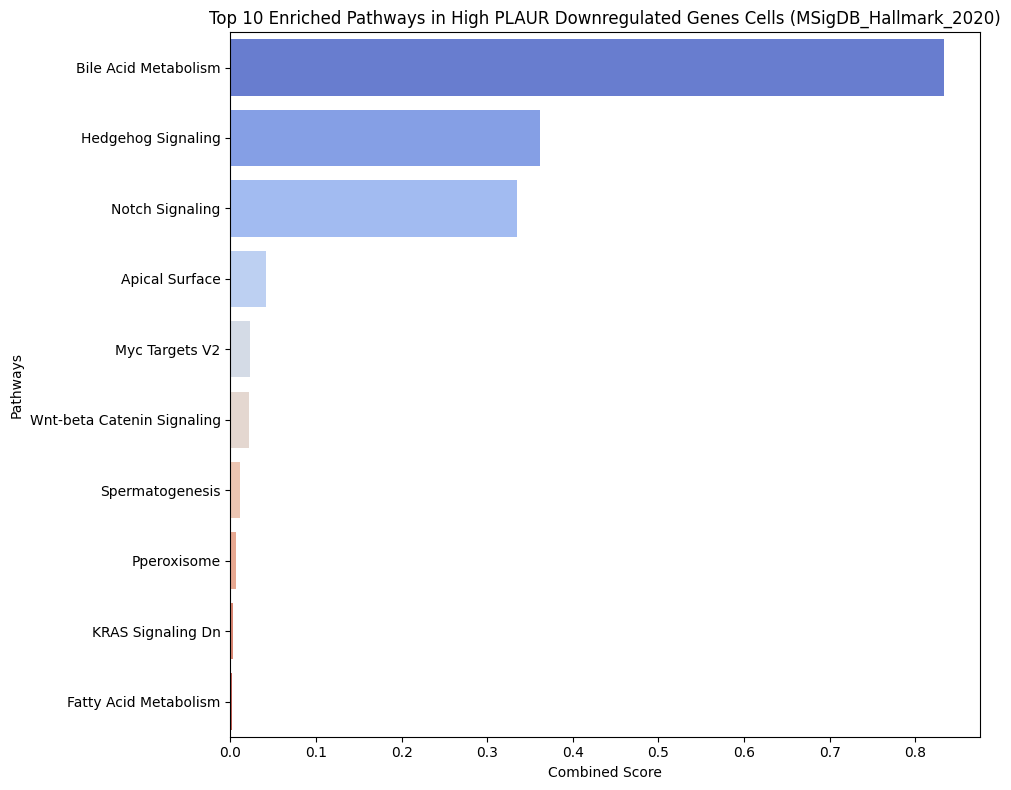

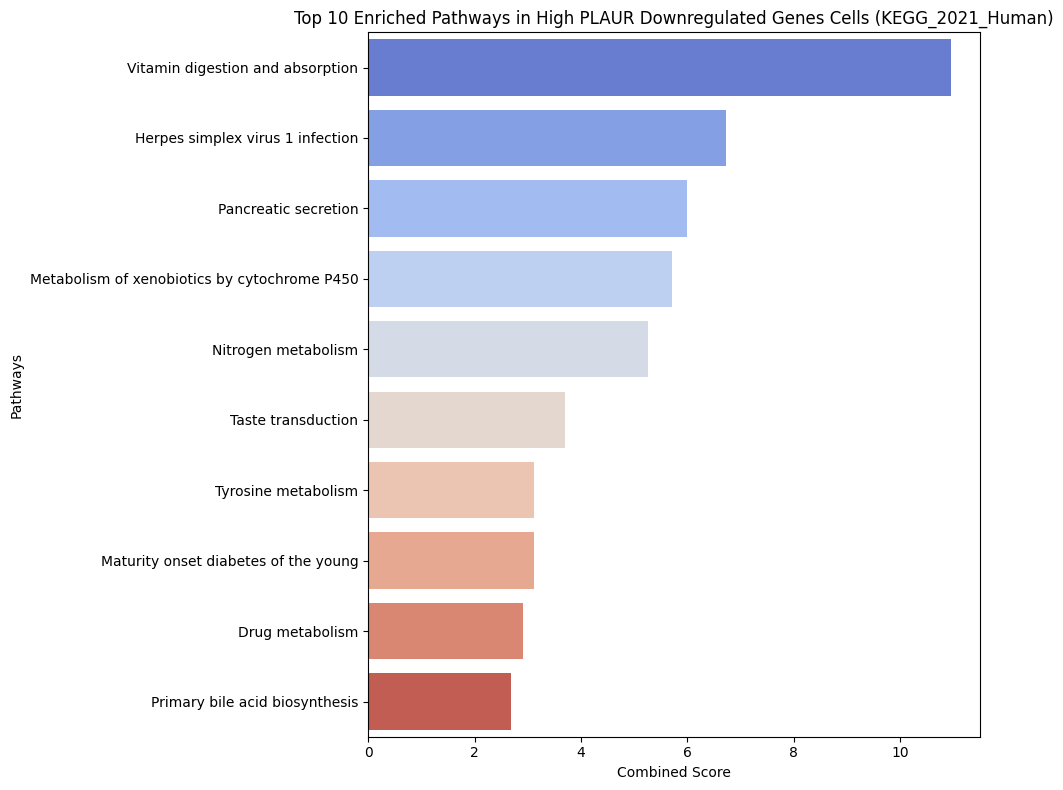

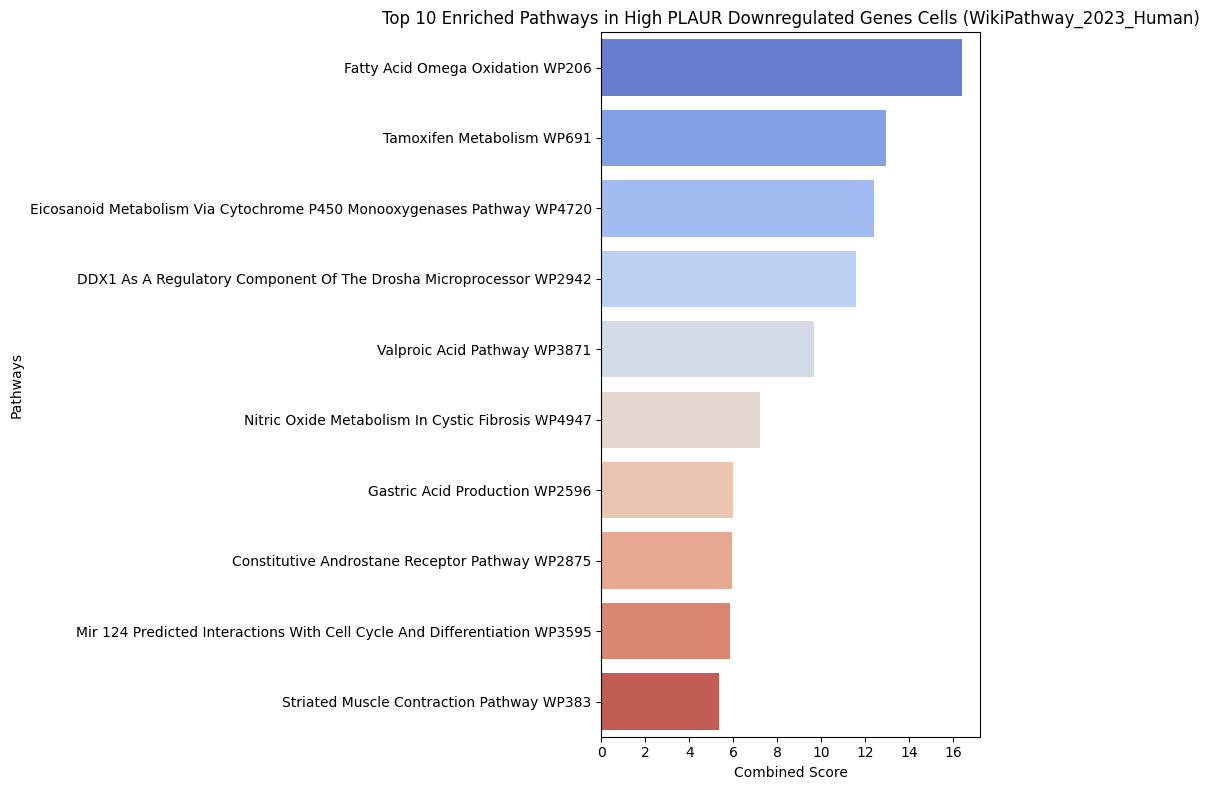

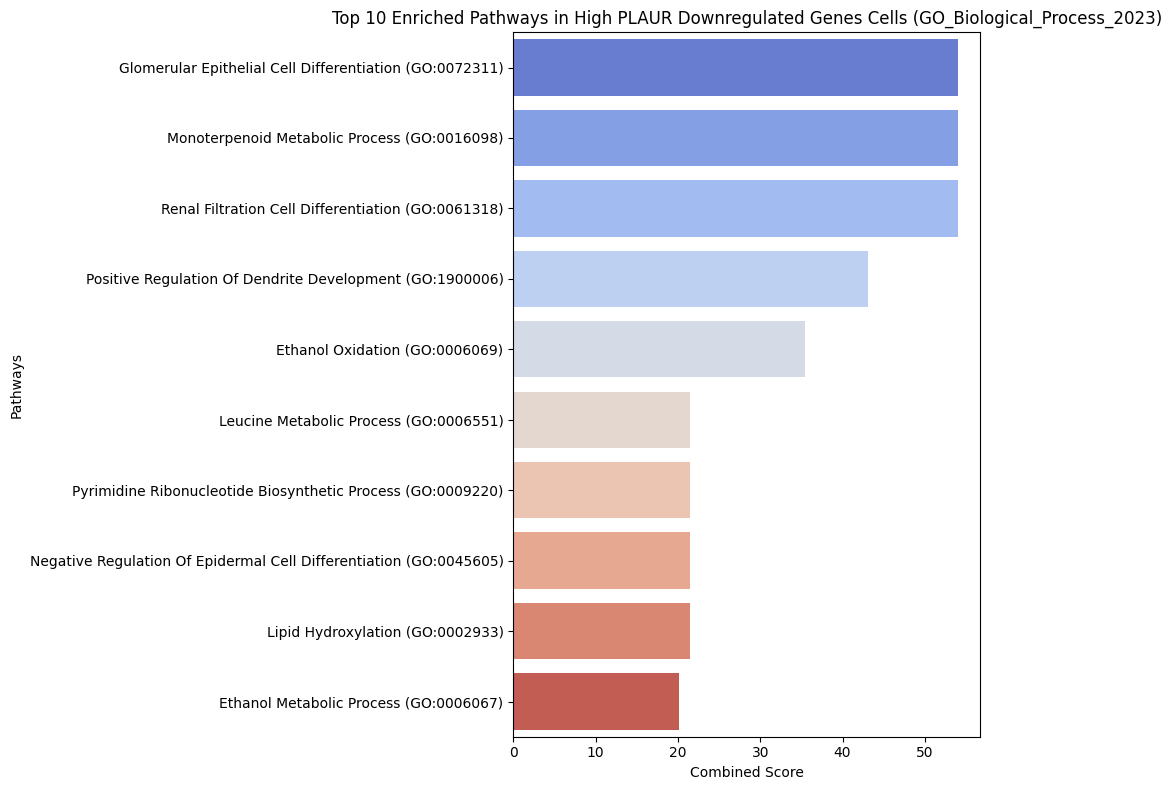

In [52]:
# Run GSEA and plot results for downregulated genes in High PLAUR cells
perform_gsea_and_plot(downregulated_genes_high_plaured,'High PLAUR Downregulated Genes', gene_sets)


In [53]:
# Print specified percentile values for PLAUR expression
for percentile in [10, 25, 50, 75, 90]:
    value = np.percentile(plaured_expr, percentile)  # Calculate the percentile on PLAUR expression
    print(f"{percentile}th percentile of PLAUR expression: {value}")


10th percentile of PLAUR expression: 0.6696715176105499
25th percentile of PLAUR expression: 0.9092190712690353
50th percentile of PLAUR expression: 1.3273549675941467
75th percentile of PLAUR expression: 2.355205774307251
90th percentile of PLAUR expression: 3.994522786140442


In [54]:
# Define high and low thresholds for PLAUR expression
high_threshold = np.percentile(plaured_expr, 90)  # 90th percentile for high expression
low_threshold = np.percentile(plaured_expr, 10)   # 10th percentile for low expression


In [55]:
# Subset cells based on high and low PLAUR expression thresholds
high_PLAUR_cells = epithelial_cells[plaured_expr > high_threshold]  # Cells with PLAUR expression above the 90th percentile
low_PLAUR_cells = epithelial_cells[plaured_expr < low_threshold]    # Cells with PLAUR expression below the 10th percentile

# Print the number of cells in each category
print(f"Number of high PLAUR expressing cells: {high_PLAUR_cells.shape[0]}")
print(f"Number of low PLAUR expressing cells: {low_PLAUR_cells.shape[0]}")


Number of high PLAUR expressing cells: 3257
Number of low PLAUR expressing cells: 3257


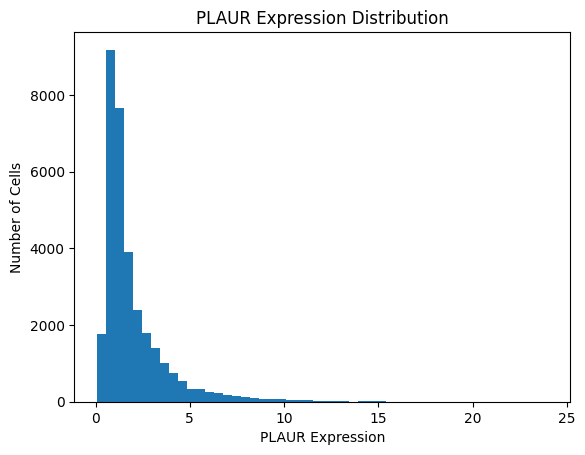

In [56]:
# Visualize the distribution of PLAUR expression
plt.hist(plaured_expr, bins=50)
plt.title('PLAUR Expression Distribution')
plt.xlabel('PLAUR Expression')
plt.ylabel('Number of Cells')
plt.show()

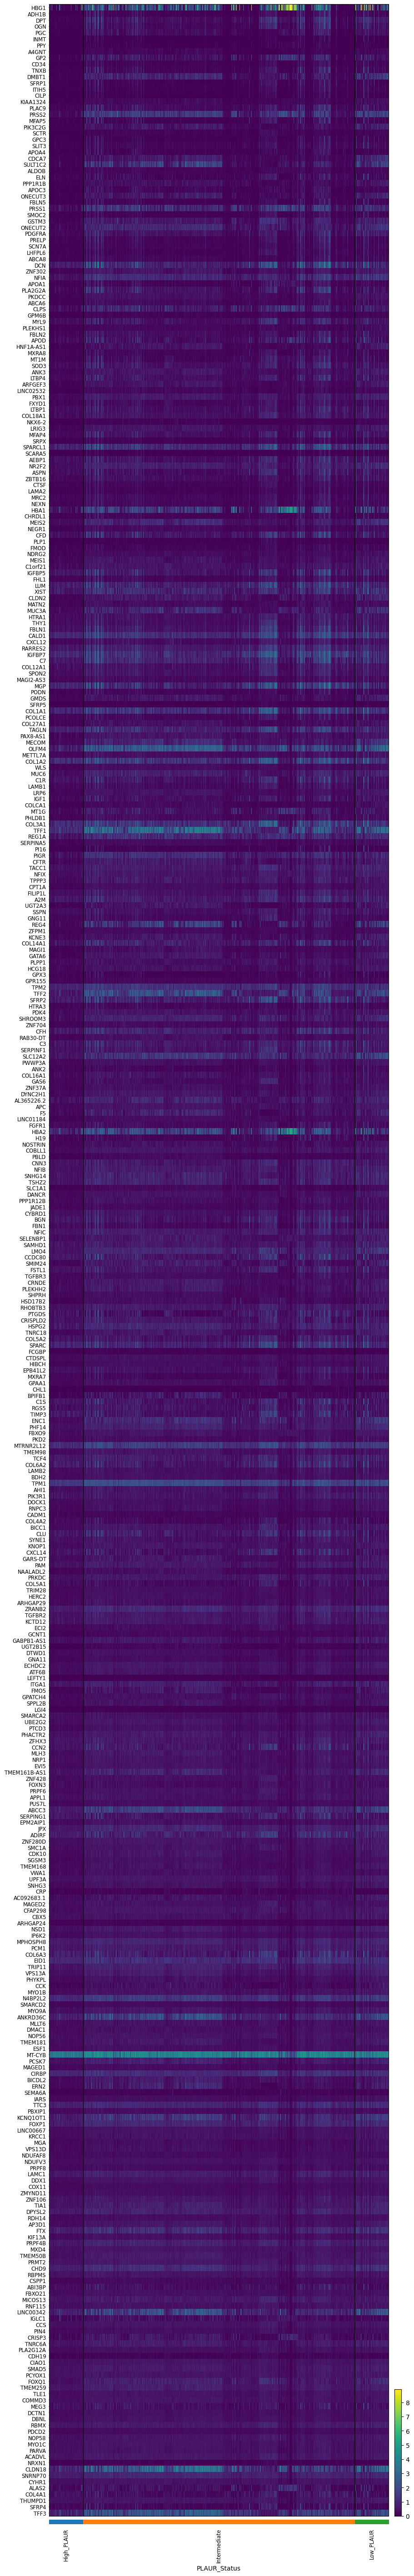

In [57]:
# Plot a heatmap of significant downregulated genes in PLAUR_Status groups
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR_down,  # List of downregulated genes to plot
    groupby='PLAUR_Status',                 # Group cells by PLAUR_Status
    swap_axes=True,                         # Swap axes to show genes on the y-axis
    layer='scvi_normalized',                # Use SCVI-normalized layer for expression values
    log=True,                               # Log-transform values for better visualization
    show_gene_labels=True                   # Display gene labels on the heatmap
)


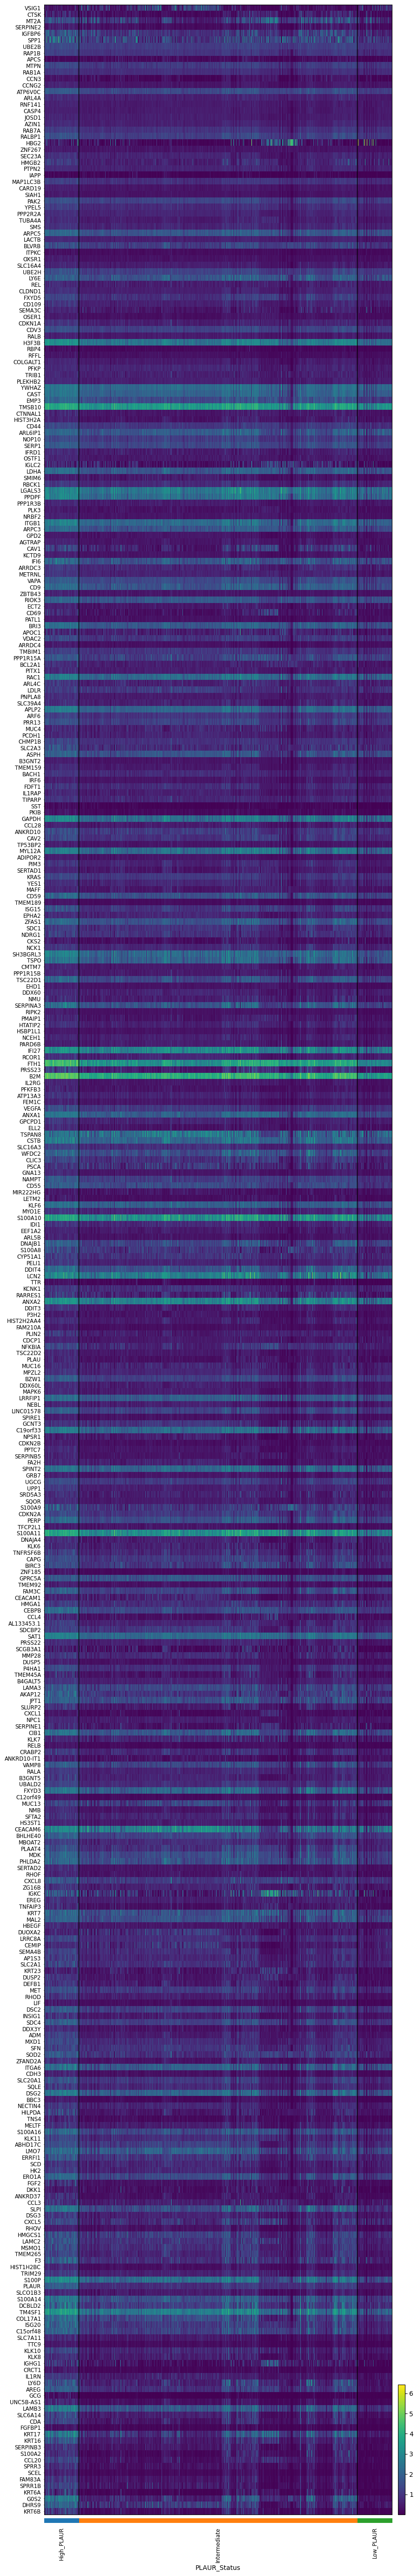

In [58]:
# Plot a heatmap of significant genes across PLAUR_Status groups
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR,      # List of significant genes to plot
    groupby='PLAUR_Status',                # Group cells by PLAUR_Status (e.g., High_PLAUR, Low_PLAUR)
    swap_axes=True,                        # Display genes on the y-axis for better readability
    layer='scvi_normalized',               # Use SCVI-normalized layer for expression values
    log=True,                              # Log-transform values for clearer visualization
    show_gene_labels=True                  # Show gene labels on the heatmap
)


In [59]:
# Assign significant_genesPLAUR to gene_list
gene_list = significant_genesPLAUR


In [60]:
# Filter gene_list to retain only genes available in epithelial_cells
available_genes = [gene for gene in gene_list if gene in epithelial_cells.var_names]


In [61]:
# Extract the scvi-normalized expression data for available genes and convert to DataFrame
expression_data = epithelial_cells[:, available_genes].to_df(layer='scvi_normalized')


In [62]:
# Add PLAUR_Status as a column in the expression_data DataFrame
expression_data['PLAUR_Status'] = epithelial_cells.obs['PLAUR_Status'].values


In [64]:
# Calculate the mean expression of each gene grouped by PLAUR_Status
mean_expression = expression_data.groupby('PLAUR_Status', observed=False).mean()


In [66]:
mean_expression

gene_symbol      VSIG1      CTSK      MT2A  SERPINE2    IGFBP6       SPP1  \
PLAUR_Status                                                                
High_PLAUR    0.501736  1.206006  5.351403  0.789334  5.467067  18.695360   
Intermediate  1.623295  0.661690  3.584267  0.478351  2.683928   4.040670   
Low_PLAUR     1.746755  0.266658  1.604153  0.240043  1.120897   2.484108   

gene_symbol      UBE2B     RAP1B      APCS      MTPN  ...    S100A2     CCL20  \
PLAUR_Status                                          ...                       
High_PLAUR    3.213392  2.555951  0.197130  3.140946  ...  1.904301  3.510247   
Intermediate  2.298750  1.761942  0.312800  2.135158  ...  0.665919  0.813221   
Low_PLAUR     1.557732  1.192322  0.137051  1.648623  ...  0.062808  0.131840   

gene_symbol      SPRR3      SCEL    FAM83A    SPRR1B     KRT6A       G0S2  \
PLAUR_Status                                                                
High_PLAUR    1.979112  0.951368  2.135907  3.895068  3.164683  13.941493   
Intermediate  0.450981  0.276323  0.609931  0.654908  0.532500   2.762013   
Low_PLAUR     0.104004  0.042665  0.085887  0.108846  0.023383   0.279649   

gene_symbol      DHRS9     KRT6B  
PLAUR_Status                      
High_PLAUR    8.580659  2.702110  
Intermediate  2.288754  0.637934  
Low_PLAUR     0.454392  0.050410  

[3 rows x 390 columns]

In [67]:
# Sort genes by mean expression in the PLAUR+ group and get the sorted gene names
sorted_genes = mean_expression.T.sort_values(by='High_PLAUR', ascending=False).index


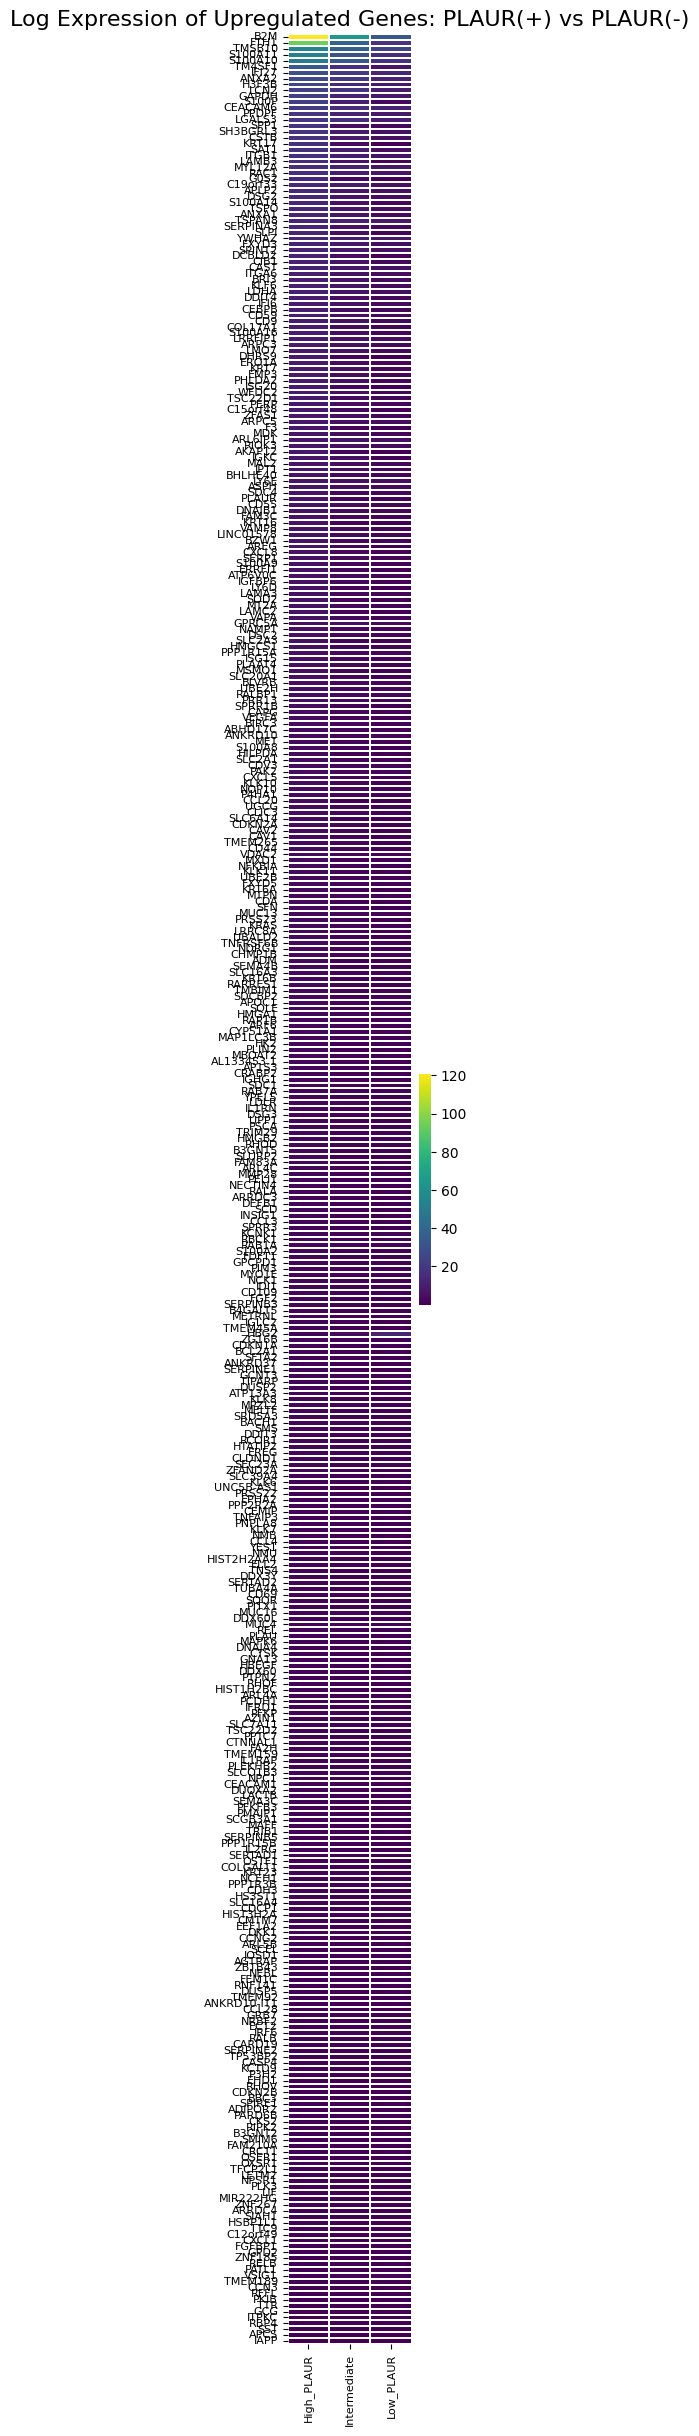

In [68]:
# Set up the figure with specified size
plt.figure(figsize=(2, 30))

# Create the heatmap for the mean expression of sorted genes
sns.heatmap(
    mean_expression.T.loc[sorted_genes],    # Use the sorted genes
    cmap='viridis',                         # Colormap for expression intensity
    annot=False,                            # Disable annotations on the heatmap
    cbar=True,                              # Display the color bar
    linewidths=0.25,                        # Thin lines between cells for clarity
    cbar_kws={"shrink": 0.1},               # Shrink the color bar for a more compact look
    yticklabels=1                           # Display gene labels with size adjustment
)

# Set the title and remove x/y axis labels
plt.title('Log Expression of Upregulated Genes: PLAUR(+) vs PLAUR(-)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust font sizes for gene labels on y-axis and status labels on x-axis
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Display the heatmap
plt.show()

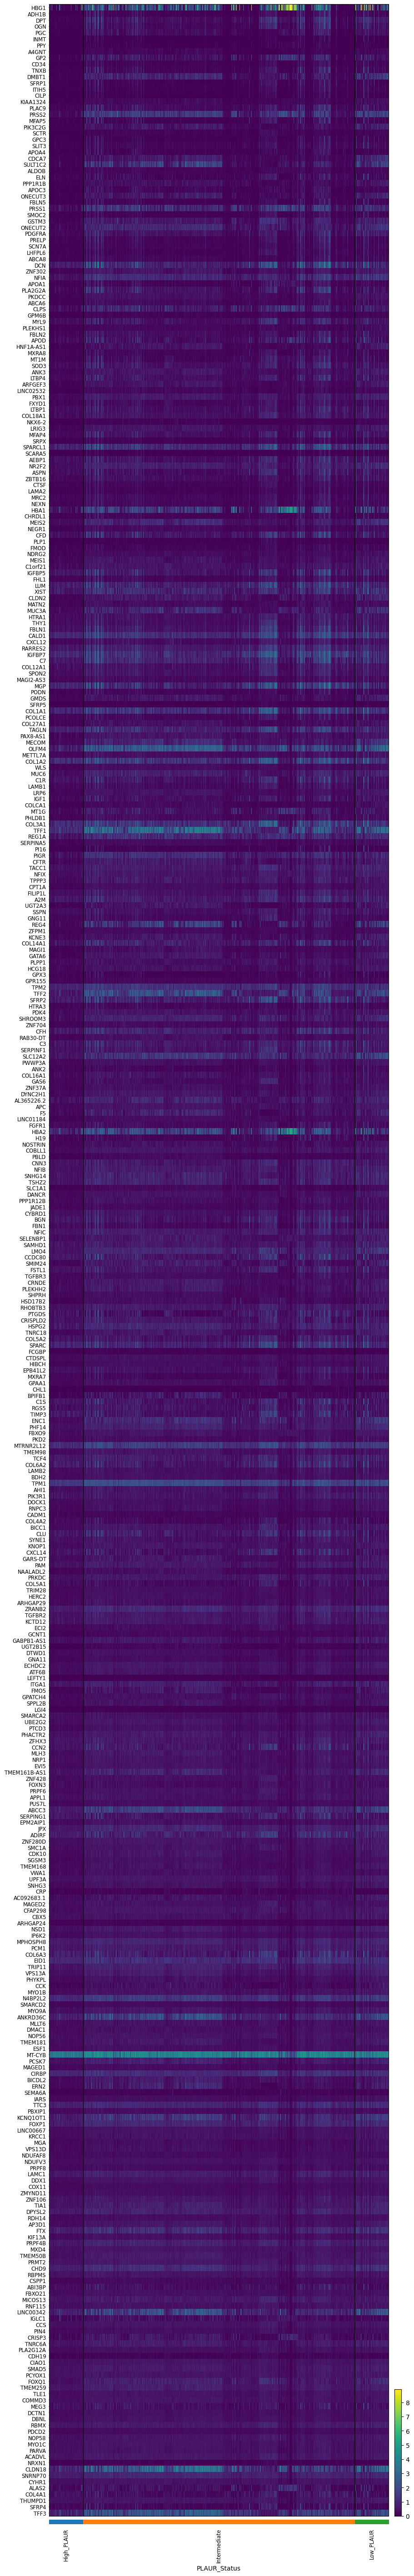

In [69]:
# Plot a heatmap of significant downregulated genes across PLAUR_Status groups
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR_down,  # List of downregulated genes to plot
    groupby='PLAUR_Status',                 # Group cells by PLAUR_Status
    swap_axes=True,                         # Display genes on the y-axis for better readability
    layer='scvi_normalized',                # Use SCVI-normalized layer for expression values
    log=True,                               # Log-transform values for clearer visualization
    show_gene_labels=True                   # Show gene labels on the heatmap
)


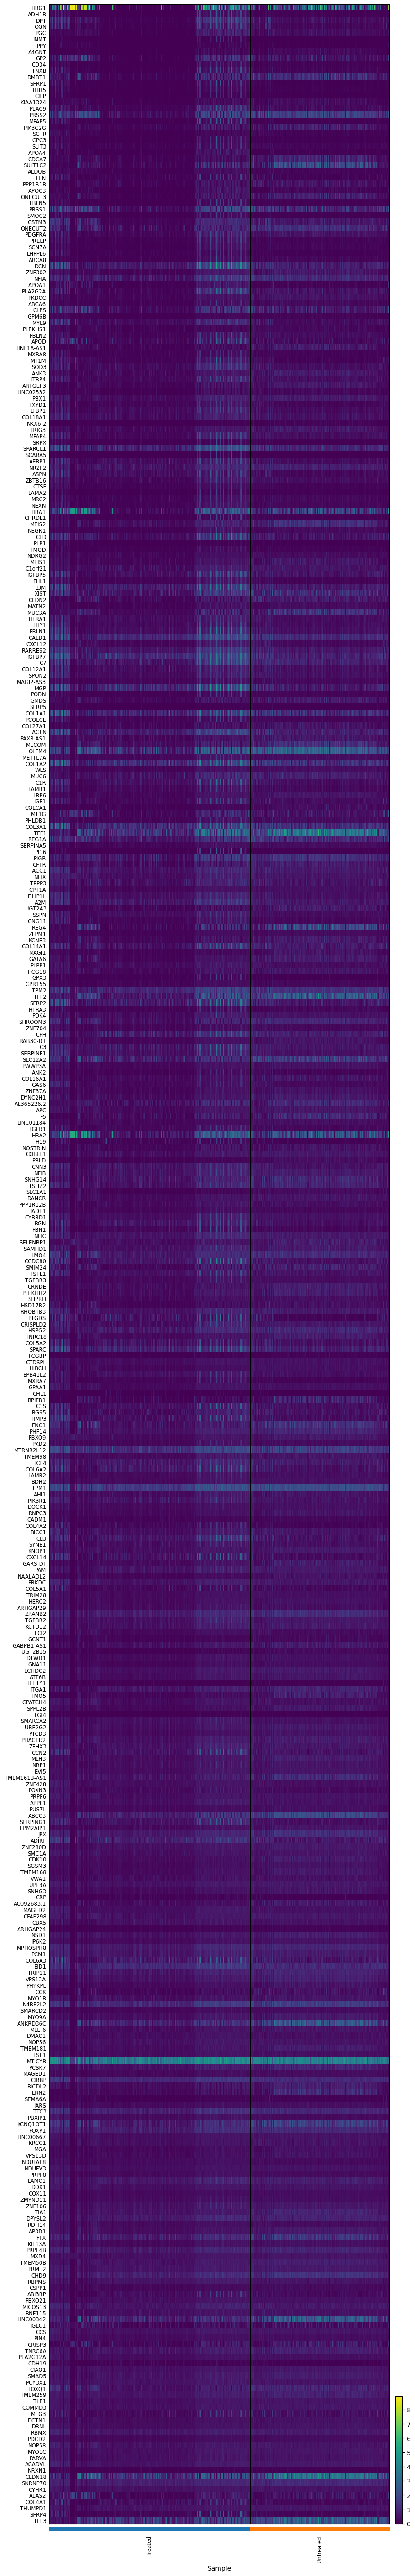

In [70]:
# Plot a heatmap of significant downregulated genes across samples grouped by the 'Sample' attribute
sc.pl.heatmap(
    epithelial_cells, 
    var_names=significant_genesPLAUR_down,  # List of downregulated genes to plot
    groupby='Sample',                       # Group cells by the 'Sample' attribute
    swap_axes=True,                         # Display genes on the y-axis for better readability
    layer='scvi_normalized',                # Use SCVI-normalized layer for expression values
    log=True,                               # Log-transform values for clearer visualization
    show_gene_labels=True                   # Show gene labels on the heatmap
)


In [71]:
# Define the gene list based on downregulated genes in PLAUR
gene_list = significant_genesPLAUR_down  # Replace with your actual gene list

# Filter the gene list to include only genes present in the dataset
available_genes = [gene for gene in gene_list if gene in epithelial_cells.var_names]


In [72]:
# Extract the scVI normalized expression values for available genes
expression_data = epithelial_cells[:, available_genes].to_df(layer='scvi_normalized')


In [73]:
# Add the PLAUR_Status labels to the expression data DataFrame
expression_data['PLAUR_Status'] = epithelial_cells.obs['PLAUR_Status'].values


In [75]:
# Calculate the mean expression of each gene for each PLAUR_Status group
mean_expression = expression_data.groupby('PLAUR_Status', observed=False).mean()


In [77]:
# Sort genes based on mean expression in the 'PLAUR-' group
sorted_genes = mean_expression.T.sort_values(by='Low_PLAUR', ascending=False).index


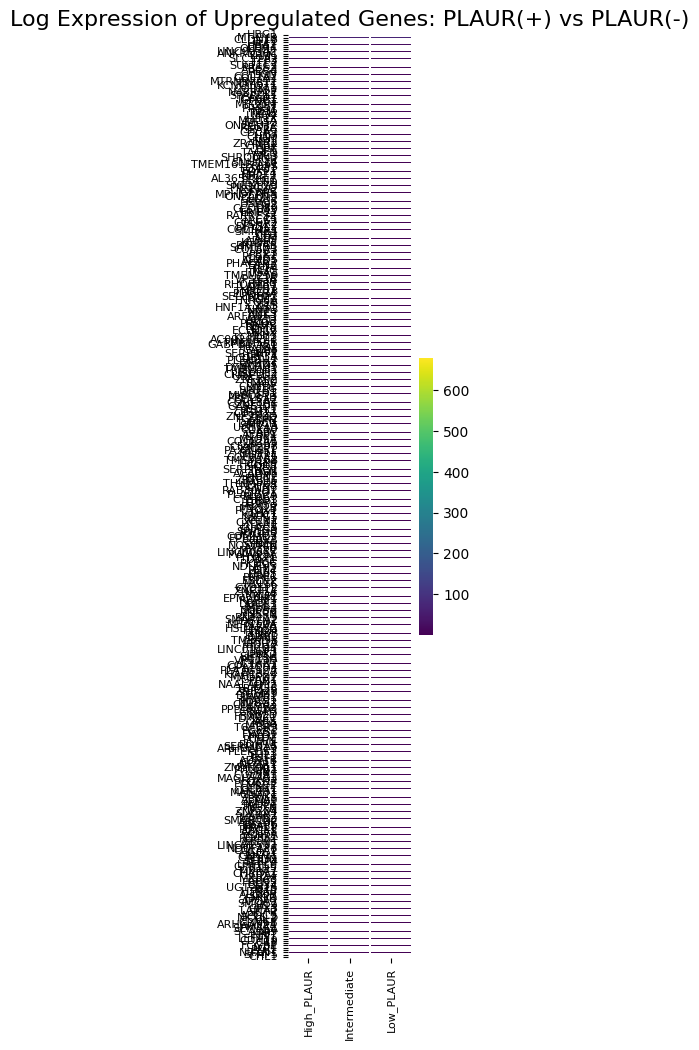

In [78]:
# Set up the figure size for the heatmap
plt.figure(figsize=(2, 12))

# Plot the heatmap for the mean expression of sorted genes
sns.heatmap(
    mean_expression.T.loc[sorted_genes],  # Use the sorted genes based on PLAUR- expression
    cmap='viridis',                       # Colormap for expression intensity
    annot=False,                          # Disable annotations on the heatmap
    cbar=True,                            # Show the color bar
    linewidths=0.25,                      # Thin lines between cells for clarity
    cbar_kws={"shrink": 0.3},             # Shrink the color bar for a compact look
    yticklabels=1                         # Display gene labels
)

# Add a title and remove x/y axis labels
plt.title('Log Expression of Upregulated Genes: PLAUR(+) vs PLAUR(-)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust font sizes for gene labels on y-axis and status labels on x-axis
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Display the heatmap
plt.show()